# **给 Colab 用户的注意事项**

# **不要直接在此文件里写内容——你的进度可能会丢失！**

# **开始前一定要先另存为副本。**

如何复制文件

1. 点击左上角的“File”。
> *如果看不到菜单栏（比如“File”或“Runtime”），点右上角的“v”标志展开它。*

2. 选择“Save a copy in Drive”

3. 把复制的文件名改成 “YOURNAMEs_FileName.ipynb”。
> 例如：你叫 Olivia，文件名改成 Olivias_FileName.ipynb



---

* 勾选标记（✅）不会保存。如果用 Chrome 的刷新按钮重新加载页面，它们会消失。<br>
如果想暂停，下次接着做，可以新建一个文本单元写上“SO FAR DONE”之类的字。

---

* 在 Colab 中，**之前的输出内容会每30到90分钟自动清空**。<br>
  因此你经常会碰到 `~~ is not defined` 的错误。

  🔁 遇到 `~~ is not defined` 错误怎么办？
  1. 先确认变量名拼写完全正确。<br>
  2. 拼写没错仍报错，**点选你想重启的单元格**。<br>
  3. 点击“Runtime”（左上）→ 选择“Run before”。<br>
    → 这会**重新运行之前的所有单元**。
  4. 再运行当前单元。

  如果按上述步骤操作后，错误依旧，<br>
  那就可能是你之前单元里的 TODO 答案写错了。<br>
  请检查答案是否正确，或者找 ChatGPT 或其他编程助手帮忙。

# **Preparation**

本节仅加载前面章节的内容。<br>
只需运行代码即可，无需阅读。<br>
你也可以直接跳过。<br>

In [ ]:
# 下载文件
!wget https://raw.githubusercontent.com/HayatoHongo/Everyones_nanoGPT/main/input.txt -O input.txt
# 以 utf-8 编码加载刚下载的名为 input.text 的文件。
with open("input.txt", 'r', encoding = 'utf-8') as f:
    text = f.read()

# 一个用于美观显示张量的函数（可跳过）
import torch
import torch.nn as nn
import torch.nn.functional as F

def print_formatted_tensor(*args, width=6, decimals=2):
    """
    将英文注释、文档字符串和 print 语句简洁友好地翻译成简体中文。    A function that neatly formats and displays a PyTorch Tensor, and also prints its size.

    Example usage:
        print_formatted_tensor("名称", tensor)
        print_formatted_tensor(tensor)

    Args:
        *args: If given 1 argument, it is treated as a tensor.
               If given 2 arguments, the first is treated as the name, the second as the tensor.
        width (int): Display width for each number (default: 6)
        decimals (int): Number of decimal places to show (default: 2)
    """
    将英文注释、文档字符串和 print 语句简洁、友好、自然地翻译成简体中文。
    # 从参数中确定张量和名称
    if not args:
        raise ValueError("At least one argument is required.")
    if isinstance(args[0], str):
        if len(args) < 2:
            raise ValueError("Tensor is not specified.")
        name, tensor = args[0], args[1]
    else:
        name, tensor = None, args[0]

    # 将张量转换为列表
    tensor_list = tensor.detach().cpu().tolist()

    def format_list(lst, indent):
        """格式化递归嵌套列表并返回字符串"""
        # 如果内容是列表，则重新返回
        if isinstance(lst, list) and lst and isinstance(lst[0], list):
            inner = ",\n".join(" " * indent + format_list(sub, indent + 2) for sub in lst)
            return "[\n" + inner + "\n" + " " * (indent - 2) + "]"
        # 用于数字列表
        return "[" + ", ".join(f"{v:{width}.{decimals}f}" for v in lst) + "]"

    # 格式化字符串（最外层的方括号已移除）
    formatted = format_list(tensor_list, indent=9)
    inner_formatted = formatted[1:-1].strip()

    # 结果输出
    if name:
        print(name)
    print(f"Tensor Size: {list(tensor.size())}")
    print("张量([")
    print("" * 9 + inner_formatted)
    print("" * 7 + "])")

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        # 定义一个嵌入表，大小为词汇量 x 嵌入维度数
        self.token_embedding_table = nn.Embedding(vocab_size, embedding_dim)

    def embed(self, input_indices):
        # 获取对应输入索引的嵌入向量
        return self.token_embedding_table.forward(input_indices)

# 定义位置嵌入模块
class PositionEmbedding(nn.Module):
    def __init__(self, input_sequence_length, embedding_dim):
        super().__init__()
        # 位置嵌入层
        self.position_embedding_layer = nn.Embedding(input_sequence_length, embedding_dim)

    def forward(self, input_indices):
        sequence_length = input_indices.shape[1]  # 获取序列长度
        position_indices = torch.arange(sequence_length, device=input_indices.device)  # 位置索引生成
        position_embeddings = self.position_embedding_layer(position_indices)  # 位置嵌入
        return position_embeddings

class EmbeddingModule(nn.Module):
    def __init__(self, vocab_size, config):
        super().__init__()
        # 为每个标记嵌入的层
        self.token_embedding_layer = TokenEmbedding(vocab_size = vocab_size, embedding_dim = config.embedding_dim)
        self.position_embedding_layer = PositionEmbedding(input_sequence_length = config.input_sequence_length, embedding_dim = config.embedding_dim)

    def forward(self, input_indices):
        # 获取token嵌入
        token_embeddings = self.token_embedding_layer.embed(input_indices)

        # 获取位置嵌入
        position_embeddings = self.position_embedding_layer.forward(input_indices)

        # 添加词元嵌入和位置嵌入
        embeddings = token_embeddings + position_embeddings
        return embeddings

class AttentionHead(nn.Module):
    def __init__(self, head_size, config):
        super().__init__()
        self.key_fc= nn.Linear(config.embedding_dim, head_size, bias=False)
        self.query_fc = nn.Linear(config.embedding_dim, head_size, bias=False)
        self.value_fc = nn.Linear(config.embedding_dim, head_size, bias=False)

        # 掩码通过下三角矩阵创建（保持自注意力的因果关系）
        self.register_buffer('tril', torch.tril(torch.ones(config.input_sequence_length, config.input_sequence_length)))

        # 丢弃法
        self.dropout = DeterministicDropout(config.dropout_rate)
        self.head_size = head_size

    def forward(self, input_tensor):
        B, T, C = input_tensor.shape  # 批次，令牌长度，嵌入通道

        key = self.key_fc.forward(input_tensor)     # （批次大小，序列长度，头部大小）
        query = self.query_fc.forward(input_tensor)   # (B, T, head_size)
        value = self.value_fc.forward(input_tensor)   # (B, T, head_size)

        # 计算注意力得分 (QK^T) * self.head_size **(-0.5)
        attention_scores = query @ key.transpose(-2, -1) * self.head_size**(-0.5)

        # 已应用掩码
        attention_scores = attention_scores.masked_fill(self.tril[:T, :T] == 0, float('-inf'))

        # Softmax → Dropout → 加权和
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        out = attention_weights @ value  # (B, T, head_size)
        return out

class DeterministicDropout(nn.Module):
    def __init__(self, p=0.1, seed=199):
        super().__init__()
        self.p = p
        # 创建一个固定的随机数生成器
        self.generator = torch.Generator()
        self.generator.manual_seed(seed)

    def forward(self, x):
        if self.training:
            # 使用固定生成器生成随机数
            mask = (torch.rand(x.shape, generator=self.generator, device=x.device, dtype=x.dtype) > self.p)
            return x * mask / (1 - self.p)
        else:
            return x

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.num_attention_heads = config.num_attention_heads
        self.embedding_dim = config.embedding_dim

        # 头大小是嵌入维度数除以注意力头数。在此示例中，8/2 = 4 是 self.head_size。
        self.head_size = int(self.embedding_dim / self.num_attention_heads)

        # 使用 ModuleList 管理多个头部
        self.attention_heads = nn.ModuleList([
            AttentionHead(self.head_size, config)
            for _ in range(self.num_attention_heads)
        ])

        # 用于混合每个头输出的线性层
        self.output_projection = nn.Linear(self.embedding_dim, self.embedding_dim)

        # 输出层的丢弃法
        self.dropout = DeterministicDropout(config.dropout_rate)

    def forward(self, input_tensor):
        # 获取每个头的输出
        head_outputs_list = [head(input_tensor) for head in self.attention_heads]  # （B，T，head_dim）的列表

        # 将所有头的输出拼接 → (B, T, embedding_dim)
        concatenated = torch.cat(head_outputs_list, dim=-1)

        # 将输出与线性变换混合
        projected = self.output_projection(concatenated)

        # 对最终输出应用 dropout
        output = self.dropout(projected)

        return output

class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.fc1 = nn.Linear(config.embedding_dim, config.hidden_dim)  # 第一层
        self.relu = nn.ReLU()  # 激活函数
        self.fc2 = nn.Linear(config.hidden_dim, config.embedding_dim)  # 第二层全粘结层
        self.dropout = DeterministicDropout(config.dropout_rate) # 丢弃法

    def forward(self, attention_output_tensor):
        hidden_tensor = self.fc1(attention_output_tensor)

        activated_tensor = self.relu(hidden_tensor)

        output_tensor = self.fc2(activated_tensor)

        final_output_tensor = self.dropout(output_tensor)

        return final_output_tensor

# 配置类，存储模型设置
class ModelConfig:
    batch_size = 1  # 一次处理的数据量（批处理大小）
    input_sequence_length = 8  # 输入数据长度（序列长度）
    embedding_dim = 8  # 嵌入层大小（特征向量的维度数）
    hidden_dim = 16 # FeedForward 层中隐藏层大小
    num_attention_heads = 2  # 注意机制头数
    dropout_rate = 0.1  # 丢弃概率

# 验证您的设置
config = ModelConfig()

# 我刚把目前的流程整理了一下，这样我就可以跳过它了
torch.manual_seed(1337)

# 正在创建 EmbeddingModule 实例。
embedding_module = EmbeddingModule(vocab_size = 65, config = config)
layer_norm1 = nn.LayerNorm(config.embedding_dim)
layer_norm2 = nn.LayerNorm(config.embedding_dim)
multiheadattention = MultiHeadAttention(config = config)
feedforward = FeedForward(config)

# 兼容 Let's he。（批量大小，令牌长度）=（1，8）
sample_input_tokens = torch.tensor([[24, 43, 58, 5, 57, 1, 46, 43]])

embeddings = embedding_module.forward(sample_input_tokens)
norm_embeddings = layer_norm1(embeddings)
multihead_attention_output = multiheadattention.forward(norm_embeddings)
residual_connection_output = multihead_attention_output + embeddings
residual_connection_output_norm = layer_norm2(residual_connection_output)
feedforward_output = feedforward.forward(residual_connection_output_norm)
print_formatted_tensor("前馈输出", feedforward_output)

# **Chapter 9: TransformerBlock Class**

将迄今为止的所有步骤结合起来，构建一个 Transformer 块。

下图中的蓝色块就是 TransformerBlock，

请注意，你不需要包含 Token 和 Position Embedding。

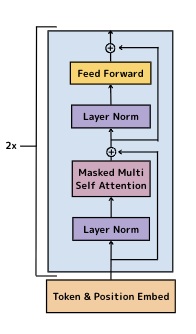

### **Section 1: 定义一个类**

🔘 **Options**：可能会有你用不到的额外选项。

`self.multihead_attention`　`self.layer_norm1`　`self.layer_norm2`　`attention_output`　`normed_input`　`self.feed_forward`　`residual_attention`　`normed_attention`　`feedforward_output`

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(config.embedding_dim)
        self.layer_norm2 = nn.LayerNorm(config.embedding_dim)

        self.multihead_attention = MultiHeadAttention(config=config)
        self.feed_forward = FeedForward(config=config)

    def forward(self, input_tensor):
        normed_input = ______________(input_tensor) # 对输入应用层归一化
        attention_output = __________________(normed_input) # 应用多头注意力
        residual_attention = ___________ + ___________ # 添加“before! layernorm1!”
        normed_attention = ______________(residual_attention) # 再次对残差输出应用LayerNorm
        feedforward_output = _____________(normed_attention) # 应用前馈网络（FFN）
        final_output = _____________ + _______________ # 添加“before” layernorm2！

        return final_output

<details>
<summary>点击此处显示/隐藏答案</summary>

```python
class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()

        # 每个 LayerNorm 实例都保存自己的缩放参数 beta 和 gamma。
        self.layer_norm1 = LayerNorm(config.embedding_dim)
        self.layer_norm2 = LayerNorm(config.embedding_dim)

        self.multihead_attention = MultiHeadAttention(config=config)
        self.feed_forward = FeedForward(config=config)

    def forward(self, input_tensor):
        # forward 方法省略。
        normed_input = self.layer_norm1(input_tensor)  # 对输入应用 Layer Norm
        attention_output = self.multihead_attention(normed_input)  # 执行多头注意力
        residual_attention = attention_output + input_tensor  # 加上“LayerNorm1之前”的输入
        normed_attention = self.layer_norm2(residual_attention)  # 对残差结果再次应用 LayerNorm
        feedforward_output = self.feed_forward(normed_attention)  # 应用前馈网络（FFN）
        final_output = feedforward_output + residual_attention  # 加上“LayerNorm2之前”的值！

        return final_output

```

In [ ]:
# 存储模型设置的配置类
class ModelConfig:
    batch_size = 1  # 每次处理的数据数量（批量大小）
    input_sequence_length = 8  # 输入数据长度（序列长度）
    embedding_dim = 8  # 嵌入层大小（特征向量的维度数）
    hidden_dim = 16 # 前馈层中的隐藏层大小
    num_attention_heads = 2  # 注释机制头编号
    dropout_rate = 0.1  # 丢弃概率

In [ ]:
# 调整种子值
torch.manual_seed(1337)

# 创建一个 ModelConfig 实例。无配置参数（构造函数）。
config = ModelConfig()

# 创建 EmbeddingModule 实例。
embedding_module = EmbeddingModule(vocab_size = 65, config = config)

# 创建一个 Transformer 块实例。
transformer_block1 = # TODO: 定义 TransformerBlock 实例。
transformer_block2 = # TODO: 定义 TransformerBlock 实例。

# 兼容 Let's he。（批量大小，令牌长度）=（1，8）
sample_input_tokens = torch.tensor([[24, 43, 58, 5, 57, 1, 46, 43]])
sample_embeddings = embedding_module.forward(sample_input_tokens)

# 通过第一个 Transformer 块
transformer_block1_output = # TODO: 实例.方法(参数)。forward 方法通常是可选的。
print_formatted_tensor("transformer_block1_output", transformer_block1_output)

transformer_block2_output = # TODO: 实例.方法(参数)。forward 方法通常是可选的。
print_formatted_tensor("transformer_block2输出", transformer_block2_output)

**`Check Point`** <label><input type="checkbox"> ← 如果上面的结果与下面的答案匹配，请勾选此框<label>

```
transformer_block1_output
Tensor Size: [1, 8, 8]
tensor([
         [
           [  0.14,  -2.19,   2.87,   0.55,   2.39,   0.14,   0.70,  -0.16],
           [ -0.45,  -1.65,   0.23,   0.60,  -1.84,   0.89,   2.54,  -1.43],
           [ -0.99,  -0.56,  -2.10,  -1.18,   2.15,   1.79,  -0.08,   0.11],
           [ -1.42,  -0.49,   0.39,  -1.45,   0.54,   2.88,  -0.46,  -0.94],
           [ -1.65,  -0.16,  -0.53,  -0.51,   1.34,   1.68,   0.84,   0.29],
           [ -0.07,   1.28,  -1.05,   0.13,   1.84,   0.53,   0.20,  -0.65],
           [ -1.80,  -0.87,   1.51,   0.97,   0.52,   2.43,  -0.77,   0.79],
           [ -0.59,   0.51,   0.26,  -1.04,   0.67,  -0.47,   1.94,   0.89]
         ]
       ])
transformer_block2_output
Tensor Size: [1, 8, 8]
tensor([
         [
           [ -0.46,  -2.47,   2.64,   0.00,   3.02,   0.14,   0.11,   0.75],
           [ -1.18,  -1.49,   0.84,   0.31,  -1.74,   1.41,   1.73,  -1.31],
           [ -1.76,  -0.16,  -1.99,  -0.89,   2.49,   2.30,  -0.84,   0.13],
           [ -2.05,  -0.29,   0.39,  -1.27,   0.68,   3.41,  -1.33,  -0.94],
           [ -2.54,   0.10,  -0.19,  -0.51,   1.42,   2.23,   0.84,   0.01],
           [ -0.74,   1.28,  -1.05,   0.65,   1.95,   0.87,  -0.51,  -1.08],
           [ -2.17,  -0.67,   1.51,   1.34,   0.61,   2.98,  -1.63,   0.46],
           [ -1.53,   0.20,   0.26,  -0.95,   0.56,   0.20,   1.33,   0.61]
         ]
       ])
```

将第一个 TransformerBlock 的输出传入第二个 TransformerBlock 进行处理。

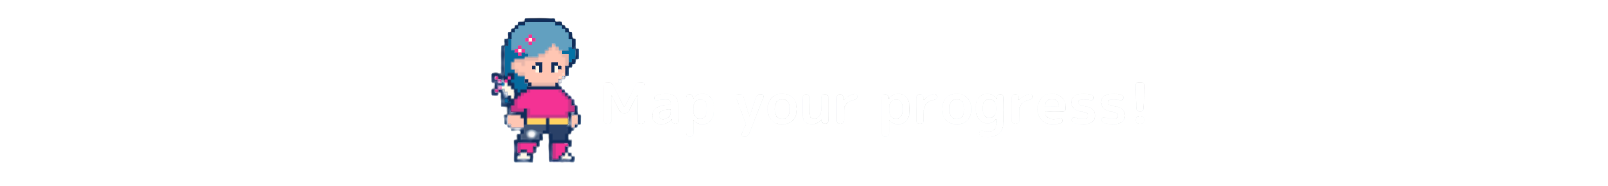

**Chapter 9: TransformerBlock Class: Section 1: Define a Class** <label><input type="checkbox"> Mark as Done</label>

**Chapter 9: TransformerBlock Class:** <label><input type="checkbox"> 标记为完成</label>